In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import os, sys, re

# Set path
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)

# 1 Introduction

Here you will assess trade flow as means of generating profit opportunities in 3 cryptotoken markets. We stress the word “opportunity” because at high data rates like these, and given the markets’ price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray.

# 2 Data

We have preprocessed level 2 exchange messages from the Coinbase WebSocket API for you into a more digestible format.

#### 2.1 Treatment

Load the 2021 data for all 3 pairs from the class website. For each one, split it into test and training sets, with your training set containing the first 20% of the data and the test set containing the remainder.

#### 2.2 Format

The data has the following structure

In [2]:
DATADIR = "../data/2021/For_Homework/"
READ_BOOK = False

books, trades = {}, {}

for filename in os.listdir(DATADIR):
    pair = re.findall(r'[A-Z]{3}-[A-Z]{3}', filename)[0]
    
    if filename[:6]=="trades":
        trades[pair] = pd.read_csv(DATADIR + filename, compression="gzip", sep='\t')
    elif filename[:4]=="book" and READ_BOOK:
        books[pair] = pd.read_csv(DATADIR + filename, compression="gzip", sep='\t')
    else:
        print(f"Not reading {filename}")

pairs = list(trades.keys())
print(f"Trades {pairs}")

Not reading book_narrow_ETH-USD_2021.delim.gz
Not reading book_narrow_ETH-BTC_2021.delim.gz
Not reading book_narrow_BTC-USD_2021.delim.gz
Trades ['ETH-BTC', 'BTC-USD', 'ETH-USD']


## Visualize the data

To understand its characteristics...

In [3]:
trades["ETH-BTC"].head(3)

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090137140737000,1618090137157544000,35690,1000000,-1
1,1618090137851379000,1618090137864544000,35700,29801980,2
2,1618090143777062000,1618090143793909000,35700,4641070,1


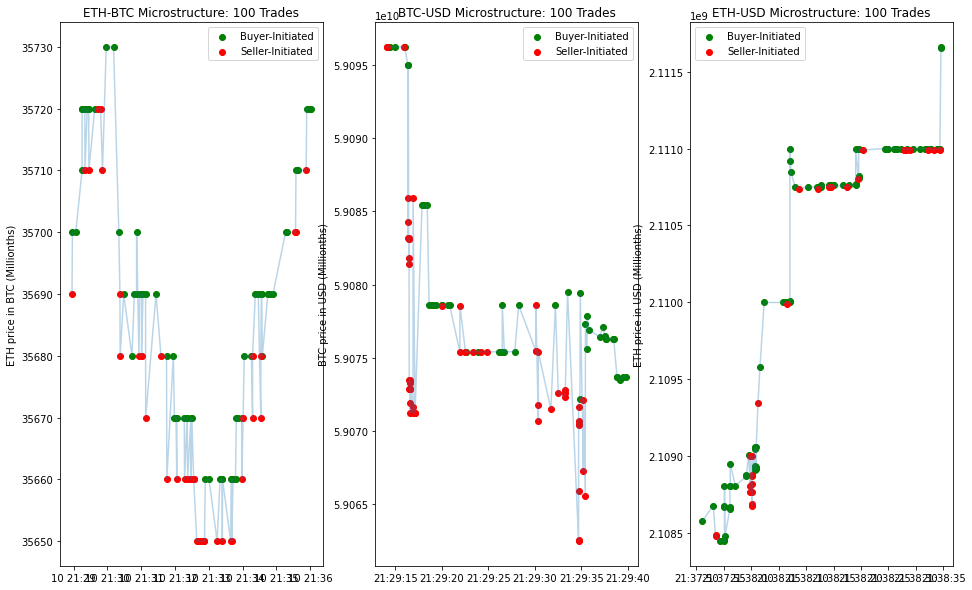

In [4]:
def visualize_microstructure(trades, pair, interval, ax):
    start, end = interval[0], interval[1]
    plot_df = trades[pair].iloc[start:end,:]
    X = pd.to_datetime(plot_df["timestamp_utc_nanoseconds"])
    Y = plot_df["PriceMillionths"]

    ax.scatter(X[plot_df["Side"]>0], Y[plot_df["Side"]>0], c='g', label="Buyer-Initiated")
    ax.scatter(X[plot_df["Side"]<0], Y[plot_df["Side"]<0], c='r', label="Seller-Initiated")
    ax.plot(X, Y, alpha=0.3)
    ax.legend()
    ax.set_title(f"{pair} Microstructure: {end-start} Trades")
    ax.set_ylabel(f"{pair.replace('-', ' price in ')} (Millionths)")


fig, axs = plt.subplots(1,3)

visualize_microstructure(trades, "ETH-BTC", [0, 100], axs[0])
visualize_microstructure(trades, "BTC-USD", [100, 200], axs[1])
visualize_microstructure(trades, "ETH-USD", [1000, 1100], axs[2])
plt.show()

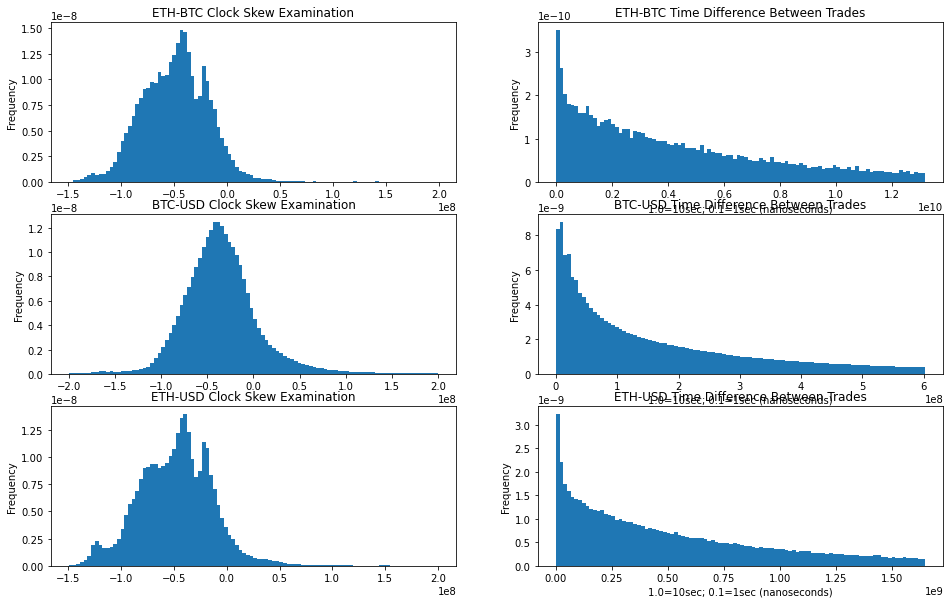

In [5]:
def visualize_delays(trades, pair, axs):
    trd_raw = trades[pair]

    latency = (trd_raw["received_utc_nanoseconds"] - trd_raw["timestamp_utc_nanoseconds"])
    latency[np.abs(latency)<2e8].plot.hist(bins=100, ax=axs[0], density=True)
    axs[0].set_title(f"{pair} Clock Skew Examination")

    dt = trd_raw["timestamp_utc_nanoseconds"].diff()

    dt[(0<dt) & (dt<dt.quantile(0.9))].plot.hist(bins=100, density=True, ax=axs[1])
    axs[1].set_title(f"{pair} Time Difference Between Trades")
    axs[1].set_xlabel("1.0=10sec; 0.1=1sec (nanoseconds)")


fig, axs = plt.subplots(3,2)

visualize_delays(trades, "ETH-BTC", axs[0])
visualize_delays(trades, "BTC-USD", axs[1])
visualize_delays(trades, "ETH-USD", axs[2])
plt.show()

## Analysis: Microstructure, Clock Skew, and Trade Time Difference



# 3 Exercise

Write code to find τ-interval trade flow F(τ) just prior2 to each trade data point3 i. Compute T-second i
forward returns4 r(T). Regress them against each other in your training set, to find a coefficient β of i
regression.

For each data point in your test set you already have F(τ), so your return prediction is rˆ := β · F(τ).
Define a threshold j for rˆ and assume you might attempt to trade whenever j < |rˆ | .

$$\begin{aligned}
    \text{Flow }&:= f_t(v,s) \\
    \text{Volume }&:= v \\
    \text{Size }&:= s \\
    \int_{t_i-\tau}^{t_i} f_t(v,s)dt &= \int_{0}^{t_i} f_t(v,s) dt - \int_{0}^{t_i-\tau} f_t(v,s) dt
\end{aligned}$$

In [6]:
def create_backward(df: pd.DataFrame, tau: int):
    df = df.copy(deep=True)
    df["dflow"] = (df["SizeBillionths"] * (df["Side"] > 0) 
                   - df["SizeBillionths"] * (df["Side"] < 0))
    df["vap"] = (df["PriceMillionths"]/1e6) * (df["SizeBillionths"]/1e9)
    df.rename(columns={"timestamp_utc_nanoseconds": "ts"}, inplace=True)
    
    # Build backward looking "flow" and "vwap"
    flow = df.set_index("ts")[["dflow", "SizeBillionths", "vap"]].cumsum()
    shift = flow.copy(deep=True)
    
    shift.index += tau
    flow.rename(columns= {"dflow": "flow",  "SizeBillionths": "vol"}, inplace=True)
    shift.rename(columns={"dflow": "sflow", "SizeBillionths": "svol", "vap": "svap"}, inplace=True)
    
    unholy = pd.concat([flow, shift], axis=0)
    unholy.sort_index(inplace=True)
    unholy[["sflow", "svol", "svap"]] = unholy[["sflow", "svol", "svap"]].fillna(method="ffill")
    
    back = unholy[["flow", "vol", "vap"]] - unholy[["sflow", "svol", "svap"]].fillna(0).values
    back.reset_index(inplace=True)
    back = back.dropna()
    back.index = df.index
    back["vwap"] = back["vap"] / back["vol"] * 1e9
    
    return back

def create_forward(df: pd.DataFrame, T: int):
    df = df.copy(deep=True)
    df["dflow"] = (df["SizeBillionths"] * (df["Side"] > 0) 
                   - df["SizeBillionths"] * (df["Side"] < 0))
    df["vap"] = (df["PriceMillionths"]/1e6) * (df["SizeBillionths"]/1e9)
    df.rename(columns={"timestamp_utc_nanoseconds": "ts"}, inplace=True)
    
    # Build forward looking "price" and "vwap"
    price = df.set_index("ts")[["PriceMillionths", "SizeBillionths", "vap"]]
    price[["SizeBillionths", "vap"]] = price[["SizeBillionths", "vap"]].cumsum()
    shift = price.copy(deep=True)
    
    shift.index -= T
    price.rename(columns={"PriceMillionths": "price", "SizeBillionths": "vol"}, inplace=True)
    shift.rename(columns={"PriceMillionths": "sprice", "SizeBillionths": "svol", "vap": "svap"}, inplace=True)
    
    unholy = pd.concat([price, shift], axis=0)
    unholy.sort_index(inplace=True)
    unholy[["sprice", "svol", "svap"]] = unholy[["sprice", "svol", "svap"]].fillna(method="ffill")
    
    fwd = unholy[["sprice"]].copy(deep=True)
    fwd.reset_index(inplace=True)
    fwd[["vol", "vap"]] = unholy[["svol", "svap"]].subtract(unholy[["vol", "vap"]].fillna(0).values, axis=0).values
    fwd = fwd[~unholy["price"].isna().values]
    fwd.index = df.index
    fwd["vwap"] = fwd["vap"] / fwd["vol"] * 1e9
    
    return fwd

def merge_together(df, back, fwd):
    new = df.merge(back, left_index=True, right_index=True)
    new.rename(columns={"received_utc_nanoseconds": "rec", "PriceMillionths": "price", 
                        "SizeBillionths": "size", "Side": "side"}, inplace=True)
    new = new.merge(fwd, left_index=True, right_index=True, suffixes=["_b", "_f"])
    new.drop(["ts_f", "ts_b"], axis=1, inplace=True)
    new.rename(columns={"timestamp_utc_nanoseconds": "ts", "sprice": "price_f"}, inplace=True)
    return new

def relevant_cols(new, tau, T):
    cut = new[["ts", "flow", "vol_b", "price", "price_f", "vwap_b", "vwap_f"]].set_index("ts")
    cut = cut[(cut.index[0] + tau < cut.index) & (cut.index < cut.index[-1] - T)]
    cut.index = pd.to_datetime(cut.index)
    cut["ret"] = np.log(cut["price_f"]/cut["price"])
    cut["ret_vw"] = np.log(cut["vwap_f"]/cut["vwap_b"])
    cut["imb"] = cut["flow"] / cut["vol_b"]
    return cut

df = trades["BTC-USD"]#.iloc[:10,:].copy(deep=True)
tau = 2*10**9
T=2*10**9

back = create_backward(df, tau)
fwd = create_forward(df, T)
new = merge_together(df, back, fwd)
cut = relevant_cols(new, tau, T)
cut.head(3)

,flow,vol_b,price,price_f,vwap_b,vwap_f,ret,ret_vw,imb
ts,,,,,,,,,
2021-04-10 21:28:54.716996,-68759030.0000,117130110.0000,59119950000,59121860000.0000,59120.3357,59122.8452,0.0000,0.0000,-0.5870
2021-04-10 21:28:54.835128,-40807160.0000,145081980.0000,59119960000,59121860000.0000,59120.7856,59122.7858,0.0000,0.0000,-0.2813
2021-04-10 21:28:54.835128,-60488830.0000,125400310.0000,59123810000,59121860000.0000,59120.3109,59122.6410,-0.0000,0.0000,-0.4824


## Example Trading Strategy

I ran a trading strategy with arbitrary parameters and tested its performance. Although the $R^2$ is miniscule and coefficients of the regression are of an incredibly small order of magnitude, it appear that the strategy properly grasps opportunities in the market. Around 2021-04-17, the market drew down significantly, and the strategy successfully sold short to capure substantial return. 

In [7]:
def regress_predict(cut, y="ret", x="flow", inqt=5):
    n = len(cut)
    insam = cut.iloc[:n//inqt]
    ousam = cut.iloc[n//inqt:].copy()
    endo=insam[y]
    exog=insam[x]

    res = sm.OLS(endo, exog).fit()
    
    valid = ousam[x]
    pred = res.predict(valid)
    
    ousam["pred"] = pred
    return res, ousam

res, ousam = regress_predict(cut, y="ret", x="flow")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ret   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                          1.091e+04
Date:                Tue, 15 Feb 2022   Prob (F-statistic):                        0.00
Time:                        16:07:52   Log-Likelihood:                      8.9098e+06
No. Observations:             1253763   AIC:                                 -1.782e+07
Df Residuals:                 1253762   BIC:                                 -1.782e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
flow        7.809e-15   7.48e-17    104.431      0.000    7.66e-15    7.96e-15
==============================================================================
Omnibus:                   478786.902   Durbin-Watson:                   0.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         73584569.400
Skew:                           0.768   Prob(JB):                         0.00
Kurtosis:                      40.500   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

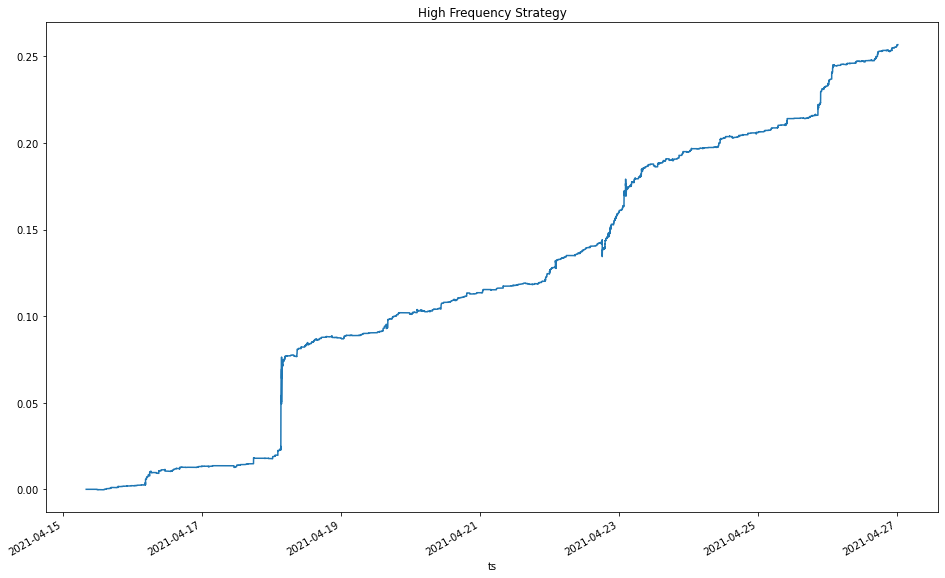

In [8]:
def run_strat(ousam, tau, thresh=.01):
    strat = ousam.copy()

    lower = strat["pred"].quantile(thresh)
    upper = strat["pred"].quantile(1-thresh)

    j = (upper-lower)/2

    strat["pos"] = (strat["pred"] > j).astype(int) - (strat["pred"] < -j).astype(int)
    strat["ts_int"] = pd.Series(strat.index.view(int)).diff().shift(-1).fillna(0).values
    strat["adj_ret"] = np.minimum(np.ones(len(strat)), strat["ts_int"] / tau) * strat["ret"]

    strat["pl"] = strat["adj_ret"] * strat["pos"]
    return strat

strat = run_strat(ousam, tau, thresh=.01)
strat["pl"].cumsum().plot()
plt.title("High Frequency Strategy")
plt.show()

## Analysis: Microstructure Characteristics

Trade imbalance tends to be relatively smooth, exibiting a bimodal distribution with peaks around + and - 1. 

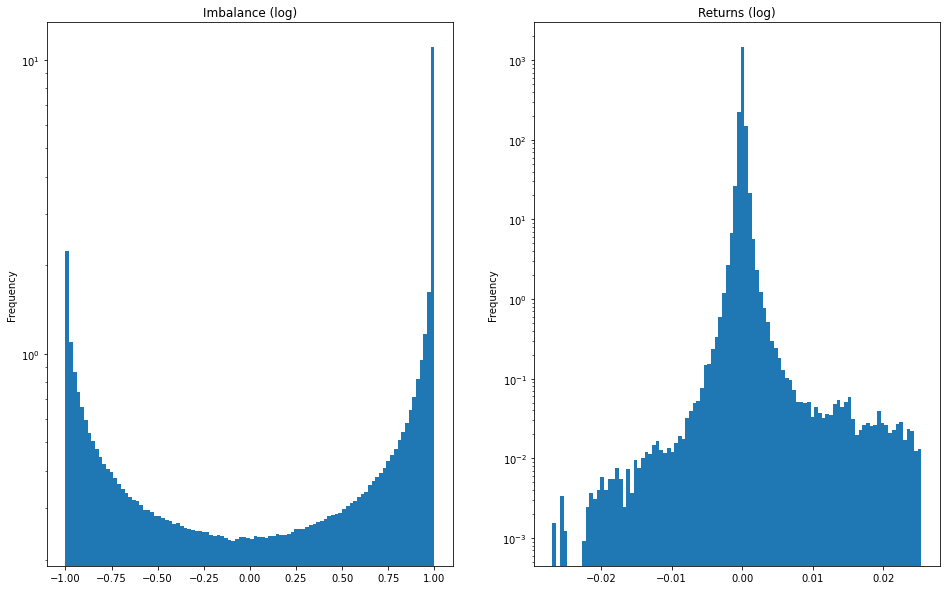

In [9]:
fig, axs = plt.subplots(1,2)

cut["imb"].plot.hist(bins=100, log=True, density=True, ax=axs[0])
axs[0].set_title("Imbalance (log)")

cut["ret"].plot.hist(bins=100, log=True, density=True, ax=axs[1])
axs[1].set_title("Returns (log)")

plt.show()

In [10]:
DEBUG = True
# QTS = [0.7, 0.8, 0.9, 0.7, 0.8, 0.9]
# SCALES = np.array([1, 1, 1, 2, 5, 10])
QTS = [0.7, 0.8, 0.9]
SCALES = np.array([2, 5, 10])

stats = []
for pair in pairs:
    df = trades[pair]
    time_diff = df["timestamp_utc_nanoseconds"].diff()
    taus = time_diff.quantile(QTS).values * SCALES
    
    if DEBUG: print(f"STARTING {pair}.")
    
    for tau in taus:
        if DEBUG: print(f"Creating Lookback\ttau={tau}")
        back = create_backward(df, tau)
        Ts = np.linspace(tau/2, tau, len(QTS))
        
        for T in Ts:
            if DEBUG: print(f"Creating Lookforward\tT={T}")
            
            fwd = create_forward(df, T)
            new = merge_together(df, back, fwd)
            cut = relevant_cols(new, tau, T)
            
            res, ousam = regress_predict(cut, y="ret", x="flow")
            rsq = res.rsquared
            tstat = res.tvalues[0]
            beta = res.params[0]
            
            for thr in [0.005, 0.01, 0.025]:
                strat = run_strat(ousam, tau, thresh=thr)
                sret = strat["pl"].cumsum()[-1]
                summ = pd.Series([pair, tau, T, thr, rsq, tstat, beta, sret, cut, strat, res], 
                                 index=["pair", "tau", "T", "thresh", "rsq", "tstat", "beta", "ret", "df", "strat", "reg"])
                stats.append(summ)

STARTING ETH-BTC.
Creating Lookback	tau=13146396400.0
Creating Lookforward	T=6573198200.0
Creating Lookforward	T=9859797300.0
Creating Lookforward	T=13146396400.0
Creating Lookback	tau=45039746000.0
Creating Lookforward	T=22519873000.0
Creating Lookforward	T=33779809500.0
Creating Lookforward	T=45039746000.0
Creating Lookback	tau=131638078000.0
Creating Lookforward	T=65819039000.0
Creating Lookforward	T=98728558500.0
Creating Lookforward	T=131638078000.0
STARTING BTC-USD.
Creating Lookback	tau=431072000.0
Creating Lookforward	T=215536000.0
Creating Lookforward	T=323304000.0
Creating Lookforward	T=431072000.0
Creating Lookback	tau=1727690000.0
Creating Lookforward	T=863845000.0
Creating Lookforward	T=1295767500.0
Creating Lookforward	T=1727690000.0
Creating Lookback	tau=6020110000.0
Creating Lookforward	T=3010055000.0
Creating Lookforward	T=4515082500.0
Creating Lookforward	T=6020110000.0
STARTING ETH-USD.
Creating Lookback	tau=1463213599.9999998
Creating Lookforward	T=731606799.9999999

In [11]:
cons = pd.concat(stats, axis=1).T
cons

,pair,tau,T,thresh,rsq,tstat,beta,ret,df,strat,reg
0,ETH-BTC,13146396400.0000,6573198200.0000,0.0050,0.0025,-4.0453,-0.0000,-0.0010,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
1,ETH-BTC,13146396400.0000,6573198200.0000,0.0100,0.0025,-4.0453,-0.0000,-0.0011,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
2,ETH-BTC,13146396400.0000,6573198200.0000,0.0250,0.0025,-4.0453,-0.0000,-0.0002,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
3,ETH-BTC,13146396400.0000,9859797300.0000,0.0050,0.0029,-4.3570,-0.0000,0.0002,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
4,ETH-BTC,13146396400.0000,9859797300.0000,0.0100,0.0029,-4.3570,-0.0000,0.0011,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
...,...,...,...,...,...,...,...,...,...,...,...
76,ETH-USD,16474168000.0000,12355626000.0000,0.0100,0.0002,3.2145,0.0000,0.0001,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
77,ETH-USD,16474168000.0000,12355626000.0000,0.0250,0.0002,3.2145,0.0000,0.0082,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
78,ETH-USD,16474168000.0000,16474168000.0000,0.0050,0.0001,2.0979,0.0000,0.0015,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
79,ETH-USD,16474168000.0000,16474168000.0000,0.0100,0.0001,2.0979,0.0000,-0.0007,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...


## Analysis: Different `tau`, `T`, and `thresh` Parameters

`tau` values chosen as a ratio of time between trades. Using only a single trade to predict future return does not make sense, so I chose parameters that have a 70% chance of having 2 or more trades, an 80% chance of having 5 or more trades, and a 90% chance of having 10 or more trades. In general, relatively longer look-back periods achieved higher regression significance and achieved higher return. However, we do not want the lookback to be too long as to trade on stale market information.

`T` values were capped at the respective `tau` value and chosen as a ratio of `tau`. It would not make sense for a smaller look-back to be used to predict a longer look-forward.

`thresh`, also known as the `j` parameter was set as a proportion of total trades to make comparison between asset pairs easy. With the Crypto-USD pairs, a higher `thresh` led to more frequent trading and higher returns as a result.

To choose a strategy that does not happen to overfit the dataset, we examine strategies that perform consistently with its neighboring parameters. Changing each parameter slightly should not alter the performance of the strategy substantively.

Within the ETH-BTC pair, `tau`=131s, `T`=65s, `thresh`=0.005 appears to perform the best in sample.

Within the BTC-USD pair, `tau`=0.6s, `T`=0.6s, `thresh`=0.025 appears to perform the best in sample.

Within the ETH-USD pair, `tau`=1.4s, `T`1.4s, `thresh`=0.025 appears to perform the best in sample.

In [12]:
def best_fits(pair):
    top = cons[(cons["pair"]==pair) & (cons["beta"] > 0)]
    display(top[top["rsq"] > top["rsq"].mean()])

best_fits("ETH-BTC")
best_fits("BTC-USD")
best_fits("ETH-USD")

,pair,tau,T,thresh,rsq,tstat,beta,ret,df,strat,reg
18,ETH-BTC,131638078000.0000,65819039000.0000,0.0050,0.0053,5.9047,0.0000,0.0009,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
19,ETH-BTC,131638078000.0000,65819039000.0000,0.0100,0.0053,5.9047,0.0000,0.0008,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
20,ETH-BTC,131638078000.0000,65819039000.0000,0.0250,0.0053,5.9047,0.0000,-0.0008,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
21,ETH-BTC,131638078000.0000,98728558500.0000,0.0050,0.0042,5.2605,0.0000,0.0014,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
22,ETH-BTC,131638078000.0000,98728558500.0000,0.0100,0.0042,5.2605,0.0000,0.0017,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
23,ETH-BTC,131638078000.0000,98728558500.0000,0.0250,0.0042,5.2605,0.0000,0.0004,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
24,ETH-BTC,131638078000.0000,131638078000.0000,0.0050,0.0036,4.8589,0.0000,0.0012,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
25,ETH-BTC,131638078000.0000,131638078000.0000,0.0100,0.0036,4.8589,0.0000,0.0009,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
26,ETH-BTC,131638078000.0000,131638078000.0000,0.0250,0.0036,4.8589,0.0000,0.0008,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...


,pair,tau,T,thresh,rsq,tstat,beta,ret,df,strat,reg
45,BTC-USD,6020110000.0000,3010055000.0000,0.0050,0.0171,149.1314,0.0000,0.0315,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
46,BTC-USD,6020110000.0000,3010055000.0000,0.0100,0.0171,149.1314,0.0000,0.0750,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
47,BTC-USD,6020110000.0000,3010055000.0000,0.0250,0.0171,149.1314,0.0000,0.1770,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
48,BTC-USD,6020110000.0000,4515082500.0000,0.0050,0.0222,170.5480,0.0000,0.0390,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
49,BTC-USD,6020110000.0000,4515082500.0000,0.0100,0.0222,170.5480,0.0000,0.0948,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
50,BTC-USD,6020110000.0000,4515082500.0000,0.0250,0.0222,170.5480,0.0000,0.2108,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
51,BTC-USD,6020110000.0000,6020110000.0000,0.0050,0.0238,176.9032,0.0000,0.0493,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
52,BTC-USD,6020110000.0000,6020110000.0000,0.0100,0.0238,176.9032,0.0000,0.1118,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
53,BTC-USD,6020110000.0000,6020110000.0000,0.0250,0.0238,176.9032,0.0000,0.2429,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...


,pair,tau,T,thresh,rsq,tstat,beta,ret,df,strat,reg
54,ETH-USD,1463213600.0000,731606800.0000,0.0050,0.0039,15.5221,0.0000,0.0044,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
55,ETH-USD,1463213600.0000,731606800.0000,0.0100,0.0039,15.5221,0.0000,0.0109,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
56,ETH-USD,1463213600.0000,731606800.0000,0.0250,0.0039,15.5221,0.0000,0.0338,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
57,ETH-USD,1463213600.0000,1097410200.0000,0.0050,0.0053,18.0654,0.0000,0.0101,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
58,ETH-USD,1463213600.0000,1097410200.0000,0.0100,0.0053,18.0654,0.0000,0.0202,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
59,ETH-USD,1463213600.0000,1097410200.0000,0.0250,0.0053,18.0654,0.0000,0.0569,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
60,ETH-USD,1463213600.0000,1463213600.0000,0.0050,0.0075,21.5893,0.0000,0.0110,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
61,ETH-USD,1463213600.0000,1463213600.0000,0.0100,0.0075,21.5893,0.0000,0.0260,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
62,ETH-USD,1463213600.0000,1463213600.0000,0.0250,0.0075,21.5893,0.0000,0.0717,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...
63,ETH-USD,5292023000.0000,2646011500.0000,0.0050,0.0041,15.8357,0.0000,0.0040,flow ...,flow ...,<statsmodels.regression.linear_model.Regressio...


# 4 Analysis

Assess the trading opportunities arising from using these return predictions in your test set. As part of this assessment, comment on the reliability of β, how you chose j, and what you might expect from using much longer training and test periods.

In [13]:
eth_btc = cons.loc[18, "strat"]
btc_usd = cons.loc[53, "strat"]
eth_usd = cons.loc[62, "strat"]

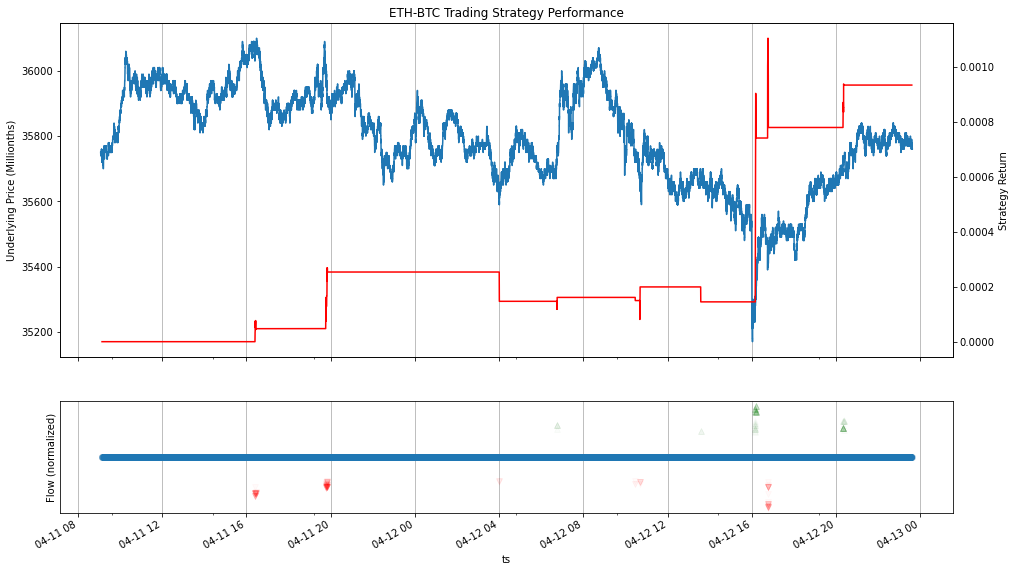

In [14]:
def visualize_strategy(to_plot, trades, pair):
    fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    axr = axs[0].twinx()
    axs[0].set_ylabel("Underlying Price (Millionths)")
    axr.set_ylabel("Strategy Return")
    
    under = trades[pair]
    under = under.iloc[len(under)//5:]
    under.index = pd.to_datetime(under["timestamp_utc_nanoseconds"])
    under["PriceMillionths"].plot(ax=axs[0])
    plt.title(f"{pair} Trading Strategy Performance")

    to_plot["pl"].cumsum().plot(ax=axr, c='r')
    f = to_plot["flow"] / to_plot["flow"].quantile(.05)
    f.plot(ax=axs[1], marker='o', ls='', alpha=0.05)
    to_plot.loc[to_plot["pos"]>0, "flow"].plot(ax=axs[1], marker='^', ls='', color='g', alpha=0.02)
    to_plot.loc[to_plot["pos"]<0, "flow"].plot(ax=axs[1], marker='v', ls='', color='r', alpha=0.02)
    axs[1].set_yticks([])
    axs[1].set_ylabel("Flow (normalized)")
    
    axs[0].grid(axis='x')
    axs[1].grid(axis='x')
    plt.show()

pair = "ETH-BTC"
to_plot = eth_btc[["pl", "flow", "pos"]]

visualize_strategy(to_plot, trades, pair)

## `ETH-BTC` Performance

It does not appear that ETH-BTC trade flow can be used to predict movements. Because we cannot trust the regression $\beta$, the optimal strategy is to use an exceptionally small `thresh` (corresponding with a prohibitively high `j` value) to prevent trading altogether.

Training and testing on longer periods will not achieve improved results because `ETH-BTC` more likely moves at a lag to `BTC-USD` and `ETH-USD`. Therefore, it is more appropriate to use flow from `BTC-USD` and `ETH-USD` to predict returns from `ETH-BTC`.

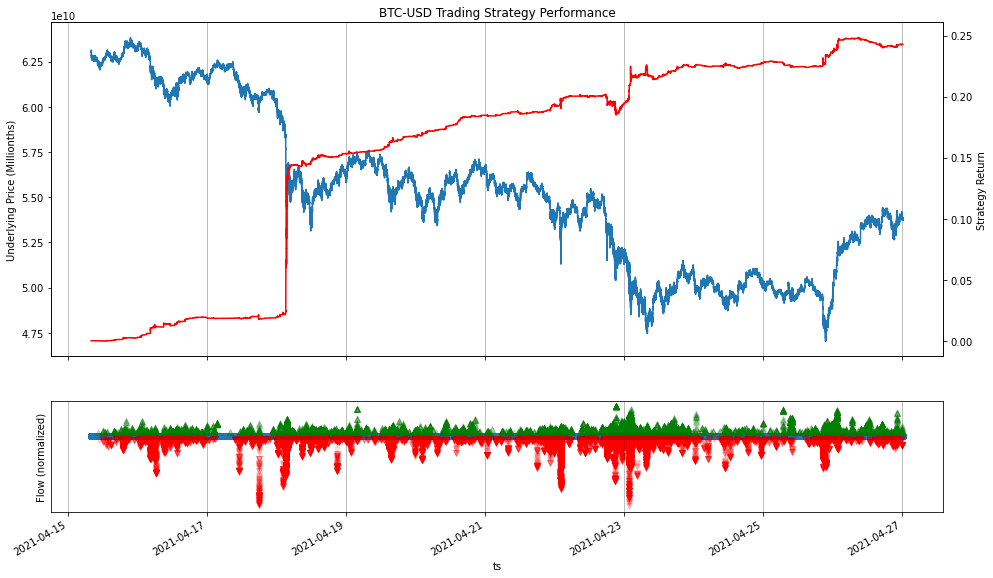

In [15]:
pair = "BTC-USD"
to_plot = btc_usd[["pl", "flow", "pos"]]

visualize_strategy(to_plot, trades, pair)

## `BTC-USD` Performance

Although the chart indicates that `BTC-USD` gained 25% within the 2 weeks the algorithm traded, a single event around 2021-04-18 accounted for roughly half the return. This event involved `BTC-USD` drawing down from \\$60,000 to \\$52,500, resulting in approximately 12.5% return.

It is however, worthwile to note that the training set created an accurate regression because of its consistent performance out of sample. We may trust the $\beta$ with relative certaintly and select `j` values that encourage increased trading.

Although entry signals on the above plot appear frequent, trades are only executed for the top 5% of strongest predicted returns. The appearance of frequent trading belies the fact that 95% of flow figures are concentrated extremely close to the zero line.

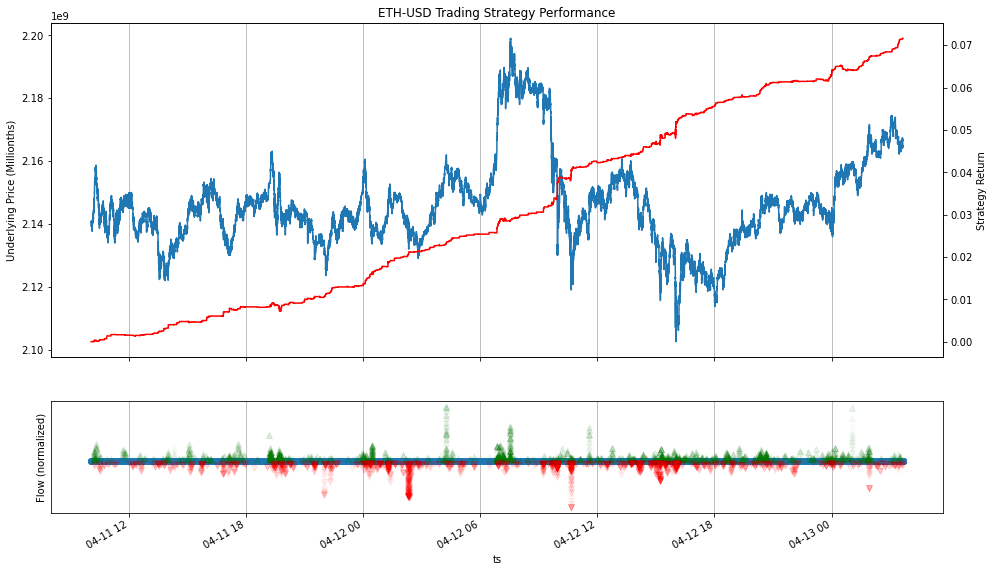

In [16]:
pair = "ETH-USD"
to_plot = eth_usd[["pl", "flow", "pos"]]

visualize_strategy(to_plot, trades, pair)

## `ETH-USD` Performance

Despite having a lower $R^2$ statistic compared with that of `BTC-USD`, the `ETH-USD` model appears to perform significantly more consistently that its counterpart. The $\beta$ of the model leads to steady returns with unsubstantial drawdowns.

Performance on longer training and testing periods will likely be consistent with results presented in this backtest. `j` is appropriately large as it trades frequently to capture profit while not taking reckless bets that diminish performance.

## Conclusion

#### Limitations of the backtests

The profitability figures of the backtests are substanitally overestimated because we assume that we can unwind positions at the same price as the last trade of the look-forward period. For example, if we place an aggressive buy at $t_i$, we are assuming that the last trade before $t_i+T$ is an aggerssive sell order. We are assuming that we could place both aggressive orders.

Using a regression without an intercept is superflous because it simply linearly scales the flow. Using flow as a signal with a `j` parameter will lead to identical trading activities and performance.

#### Future improvements

To avoid overestimation of profitability, we must incorporate best bid and offer data. By doing so, we can better model exiting our long and short positions by making the assumption that we cross the spread every time. Therefore, we must run two separate regressions for positive and negative flow to determine to simulate closing our positions at the bid and offer respectively.

A different strategy may attempt to join the best bid/offer to earn the spread from a passive order, though modelling the impact of joining the order book may be dubious.

As noted above, a single variable regression on flow without an intercept performs identically to using flow as a signal and establishing a `j` parameter based on it. However, flow may not be the single variable that predicts the price of each currency pair, so we may consider building a multivariate regression. Look-back trade imbalance, book order imbalance, and trading activity on other assets may all be used to construct a more statistically significant (or overfitted) regression to predict future return.